<a href="https://colab.research.google.com/github/SamuelEiler/wgan/blob/main/WGANsine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -qqq
!pip install --upgrade wandb
!wandb login 50457c76bb245c5d932008de50c1858da49aeeba

import wandb
#wandb.init(project="gan")

from __future__ import division
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.autograd.variable import Variable
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import numpy as np

import seaborn as sns
import plotly.express as px
from torch import autograd


sns.set(rc={'figure.figsize':(11, 8)})

import datetime 
from datetime import date
today = date.today()

import random
import json as js
import pickle
import os
import tqdm.notebook as tq

import torch
import torch.nn as nn
import random
import plotly.graph_objects as go

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random_seed = 29

np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.set_deterministic(True)

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.10.12)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
ecg = 0
import numpy as np

if ecg:

  from google.colab import drive
  drive.mount('/content/drive')

  !pip install arff2pandas

  from arff2pandas import a2p

  path = '/content/drive/MyDrive/MasterThesis/ECG_Dataset/ECG5000/'
  with open(path+'ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)
  with open(path+'ECG5000_TEST.arff') as f:
    test = a2p.load(f)

  df = train.append(test)
  df = df.sample(frac=1.0)
  df.shape

  CLASS_NORMAL = 1
  class_names = ['Normal','R on T','PVC','SP','UB']

  new_columns = list(df.columns)
  new_columns[-1] = 'target'
  df.columns = new_columns

  df.target.value_counts()

  normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
  print(normal_df.shape)

  anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
  print(anomaly_df.shape)

  from sklearn.model_selection import train_test_split
  RANDOM_SEED = 29
  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)


  train_df, val_df = train_test_split(
    normal_df,
    test_size=0.15,
    random_state=RANDOM_SEED
  )

  data = pd.DataFrame(train_df[1:][:])  

  dataPath = './dataset'  
  if not os.path.exists(dataPath):
    os.makedirs(dataPath)

  data.to_csv(dataPath + '/ecg_data_v1.csv', header = False, index = False)


  val_df, test_df = train_test_split(
    val_df,
    test_size=0.33,
    random_state=RANDOM_SEED
  )

  def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features


  train_dataset, seq_len, n_features = create_dataset(train_df)
  val_dataset, _, _ = create_dataset(val_df)
  test_normal_dataset, _, _ = create_dataset(test_df)
  test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

  import torch
  from torch.utils.data import Dataset, DataLoader
  import pandas as pd

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  class ECGData(Dataset):
    #This is the class for teh ECG Data that we need to load, transform and then use in teh dataloader.
    def __init__(self,source_file,transform = None):
      self.source_file = source_file
      self.data  = pd.read_csv(source_file, header = None)
      self.transform = transform
      
    def __len__(self):
      return self.data.shape[0]
      
    def __getitem__(self,idx):
      
      sample = self.data.iloc[idx]
      
      if self.transform:
          sample = self.transform(sample)
          
      return sample   

  """Including the function that will transform the dataframe to a pytorch tensor"""
  class PD_to_Tensor(object):
      def __call__(self,sample):
        return torch.tensor(sample.values).to(device=device, dtype=float)


  print(len(train_dataset))
  print(seq_len)
  print(n_features)
  for n in range(10):
    plt.plot(train_dataset[n])
  plt.show()

  def GetECGData(source_file):
    compose = transforms.Compose([PD_to_Tensor()])
    return ECGData(source_file ,transform = compose)





### Kaggle and imports

### Models (Generator and Discriminator)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MinibatchDiscrimination(torch.nn.Module):
   def __init__(self,input_features,output_features,minibatch_normal_init, hidden_features=16):
      super(MinibatchDiscrimination,self).__init__()
      
      self.input_features = input_features
      self.output_features = output_features
      self.hidden_features = hidden_features
      self.T = torch.nn.Parameter(torch.randn(self.input_features,self.output_features, self.hidden_features))
      if minibatch_normal_init == True:
        nn.init.normal_(self.T, 0,1)
      
   def forward(self,x):
      M = torch.mm(x,self.T.view(self.input_features,-1))
      M = M.view(-1, self.output_features, self.hidden_features).unsqueeze(0)
      M_t = M.permute(1, 0, 2, 3)
      # Broadcasting reduces the matrix subtraction to the form desired in the paper
      out = torch.sum(torch.exp(-(torch.abs(M - M_t).sum(3))), dim=0) - 1
      
      return torch.cat([x, out], 1)
    

# Use minibatch = 0 for no minibatch discriminiation layer to be used in the architecture. If minibatch > 0, then minibatch is the number of output dimensions of the MBD layer.
class Discriminator(torch.nn.Module):
  def __init__(self,seq_length,batch_size,minibatch_normal_init, n_features = 1, num_cv = 1, minibatch = 0, cv1_out= 10, cv1_k = 3, cv1_s = 4, p1_k = 3, p1_s = 3, cv2_out = 10, cv2_k = 3, cv2_s = 3 ,p2_k = 3, p2_s = 3):
      super(Discriminator,self).__init__()
      self.n_features = n_features
      self.seq_length = seq_length
      self.batch_size = batch_size
      self.num_cv = num_cv
      self.minibatch = minibatch
      self.cv1_dims = int((((((seq_length - cv1_k)/cv1_s) + 1)-p1_k)/p1_s)+1)
      self.cv2_dims = int((((((self.cv1_dims - cv2_k)/cv2_s) + 1)-p2_k)/p2_s)+1)
      self.cv1_out = cv1_out
      self.cv2_out = cv2_out


      #self.dropout = torch.nn.Dropout(0.05)

      
      #input should be size (batch_size,num_features,seq_length) for the convolution layer
      self.CV1 = torch.nn.Sequential(
                  torch.nn.Conv1d(in_channels = self.n_features, out_channels = int(cv1_out),kernel_size = int(cv1_k), stride = int(cv1_s), padding=0)
                  #,nn.InstanceNorm1d(int(cv1_out), affine=True)

                  ,torch.nn.LeakyReLU()        
                  ,torch.nn.AvgPool1d(kernel_size = int(p1_k), stride = int(p1_s))   
                 )
      
      # 2 convolutional layers
      if self.num_cv > 1:
        self.CV2 = torch.nn.Sequential(
                      torch.nn.Conv1d(in_channels = int(cv1_out), out_channels = int(cv2_out) ,kernel_size =int(cv2_k), stride = int(cv2_s), padding=0)
                      #,nn.InstanceNorm1d(int(cv2_out), affine=True)

                      ,torch.nn.LeakyReLU()
                      ,torch.nn.AvgPool1d(kernel_size = int(p2_k), stride = int(p2_s))
                  )
        
        #Adding a minibatch discriminator layer to add a cripple affect to the discriminator so that it needs to generate sequences that are different from each other.
        
        if   self.minibatch > 0:
          self.mb1 = MinibatchDiscrimination(self.cv2_dims*cv2_out,self.minibatch, minibatch_normal_init)
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv2_dims*cv2_out)+self.minibatch,1),torch.nn.Sigmoid()) # to make sure the output is between 0 and 1
        else:
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv2_dims*cv2_out),1)) # to make sure the output is between 0 and 1 
      
      # 1 convolutional layer
      else:
        #Adding a minibatch discriminator layer to add a cripple affect to the discriminator so that it needs to generate sequences that are different from each other.
        if self.minibatch > 0 :    
          self.mb1 = MinibatchDiscrimination(int(self.cv1_dims*cv1_out),self.minibatch, minibatch_normal_init)
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv1_dims*cv1_out)+self.minibatch,1),torch.nn.Dropout(0.2)) # to make sure the output is between 0 and 1
        else:
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv1_dims*cv1_out),1))  
      
      

  def forward(self,x):
      self.batch_size = x.size(0)
      x = self.CV1(x.view(self.batch_size,1,self.seq_length))
      # conv 1  -> conv2 -> dropout -> linear
      #2 Convolutional Layers
      if self.num_cv > 1:   
        x = self.CV2(x)
        #x = self.dropout(x)
        x = x.view(self.batch_size,-1)
        
        #2 CNN with minibatch discrimination
        if self.minibatch > 0:
             x = self.mb1(x.squeeze())
             x = self.out(x.squeeze())
             
        #2 CNN and no minibatch discrimination
        else:
             x = self.out(x.squeeze())
        
      # 1 Convolutional Layer
      else: 
        x = x.view(self.batch_size,-1)
       
        #1 convolutional Layer and minibatch discrimination
        if self.minibatch > 0:
             x = self.mb1(x)
             x = self.out(x)
        
        #1 convolutional Layer and no minibatch discrimination
        else:
             x = self.out(x)    
      return x
  


class Generator(torch.nn.Module):
  #seq_length not important
  def __init__(self,seq_length,batch_size,n_features = 1, hidden_dim = 50, num_layers = 2, tanh_output = False, bidirectional = False):
      super(Generator,self).__init__()
      self.n_features = n_features
      self.hidden_dim = hidden_dim
      self.num_layers = num_layers
      self.seq_length = seq_length
      self.batch_size = batch_size
      self.tanh_output = tanh_output
      self.bidirectional = bidirectional

      #self.dropout = torch.nn.Dropout(0.05)

      
      #Checking if the architecture uses a BiLSTM and setting the output parameters as appropriate.
      if self.bidirectional == True:
        self.num_dirs = 2
      else:
        self.num_dirs = 1
      
      
      self.layer1 = torch.nn.LSTM(input_size = self.n_features, hidden_size = self.hidden_dim, num_layers = self.num_layers,batch_first = True, bidirectional = self.bidirectional )
      self.out = torch.nn.Linear(self.hidden_dim,1) # to make sure the output is between 0 and 1 - removed ,torch.nn.Sigmoid()
  
  def forward(self,x):
      self.seq_length = x.size(1)
      self.batch_size = x.size(0)

      h_0 = torch.zeros(self.num_layers*self.num_dirs, self.batch_size, self.hidden_dim, requires_grad=True).to(device)
      c_0 = torch.zeros(self.num_layers*self.num_dirs, self.batch_size, self.hidden_dim, requires_grad=True).to(device)
      #x, _ = self.layer1(x.view(self.batch_size,self.seq_length,1), (h_0, c_0)) 
      x, _ = self.layer1(x.view(self.batch_size,self.seq_length, noise_features), (h_0, c_0)) #--------------------------------noise_features ---------------------------------------


      if self.bidirectional == True:
        x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)
      
      #Note that the output of the bidirectional LSTM is in the form (batch_size,seq_lenth,num_dirs*hidden_dim) To separate the directions, we can use 
      #x.view(self.batch_size,self.seq_length,self.num_dirs, self.hidden_dim)
      #x = self.dropout(x)

      x = self.out(x)

      return x.squeeze() #,hidden 

### Data Loader

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class SineData(Dataset):
  #This is the class for teh ECG Data that we need to load, transform and then use in teh dataloader.
  def __init__(self,source_file,transform = None):
    self.source_file = source_file
    self.data  = pd.read_csv(source_file, header = None)
    self.transform = transform
    
  def __len__(self):
    return self.data.shape[0]
    
  def __getitem__(self,idx):
    
    sample = self.data.iloc[idx]
    
    if self.transform:
        sample = self.transform(sample)
        
    return sample   

"""Including the function that will transform the dataframe to a pytorch tensor"""
class PD_to_Tensor(object):
    def __call__(self,sample):
      return torch.tensor(sample.values).to(device=device, dtype=float)

### Create Dataset

In [5]:
import pandas as pd
import numpy as np
import random
import os

dataPath = './dataset'  
if not os.path.exists(dataPath):
        os.makedirs(dataPath)

trainingset_size = 64 * 150
testset_size = 64 * 20

"""Create a training set of sine waves with 10000 records"""

#a = np.arange(0.1,0.9,0.02)
x = np.arange(0,20,0.4)
#r = np.arange(2,6.1,0.1)
count = 0
fs = len(x)
y = np.zeros((1,len(x)))

for n in range(trainingset_size):
  amp = random.uniform(0.1, 0.9)
  rad = random.uniform(5, 10)
  phase = random.uniform(-fs/0.5*np.pi,fs/0.5*np.pi)
  offsetY = random.uniform(-1, 1)
  y = np.append(y,  offsetY + amp*np.sin(((2*np.pi*rad*x)+phase)/fs).reshape((1,len(x))),axis = 0)
  
# for n in range(20):
#    plt.plot(y[n + 1])
# plt.show()
data = pd.DataFrame(y[1:][:])  
data.to_csv(dataPath + '/sinedata_v2.csv', header = False, index = False)

"""Creating a test set of sine waves with 3000 records"""
a = np.arange(0.1,0.9,0.02)
x = np.arange(0,20,0.5)
r = np.arange(2,6.1,0.1)
count = 0
fs = len(x)
y = np.zeros((1,len(x)))

for n in range(testset_size):
  amp = a[random.randint(0,len(a)-1)]
  rad = r[random.randint(0,len(r)-1)]
  phase = random.uniform(-1,1)*np.pi

  y = np.append(y,amp*np.sin(((2*np.pi*rad*x)+phase)/fs).reshape((1,len(x))),axis = 0)
  
data = pd.DataFrame(y[1:][:])  
data.to_csv(dataPath + '/sinedata_test_v2.csv', header = False, index = False)

### Utils

In [6]:
def noise(batchsize, seq_length, noise_features):
    rnoise = torch.ones( (batchsize, seq_length, noise_features)).to(device)
    if noise_features == 1:
      return torch.rand(batchsize, seq_length, 1)

    for b in range(batchsize):
        randoms = np.ones(noise_features)
        for nf in range(noise_features):
            randoms[nf] = random.uniform(-1,1)
        for i in range(seq_length):
            for nf in range(noise_features):
                rnoise[b][i][nf] = randoms[nf]
    return rnoise




def pdist(sample_1, sample_2, norm=2, eps=1e-5):
    n_1, n_2 = sample_1.size(0), sample_2.size(0)
    norm = float(norm)
    
    if norm == 2.:
        norms_1 = torch.sum(sample_1**2, dim=1, keepdim=True)
        norms_2 = torch.sum(sample_2**2, dim=1, keepdim=True)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * sample_1.mm(sample_2.t())
        return torch.sqrt(eps + torch.abs(distances_squared))
    else:
        dim = sample_1.size(1)
        expanded_1 = sample_1.unsqueeze(1).expand(n_1, n_2, dim)
        expanded_2 = sample_2.unsqueeze(0).expand(n_1, n_2, dim)
        differences = torch.abs(expanded_1 - expanded_2) ** norm
        inner = torch.sum(differences, dim=2, keepdim=False)
        return (eps + inner) ** (1. / norm)

def permutation_test_mat(matrix,n_1,  n_2,  n_permutations, a00=1,  a11=1,  a01=0):
    n = n_1 + n_2
    pi = np.zeros(n, dtype=np.int8)
    pi[n_1:] = 1

    larger = 0.
    count = 0
    
    for sample_n in range(1 + n_permutations):
        count = 0.
        for i in range(n):
            for j in range(i, n):
                mij = matrix[i, j] + matrix[j, i]
                if pi[i] == pi[j] == 0:
                    count += a00 * mij
                elif pi[i] == pi[j] == 1:
                    count += a11 * mij
                else:
                    count += a01 * mij
        if sample_n == 0:
            statistic = count
        elif statistic <= count:
            larger += 1

        np.random.shuffle(pi)

    return larger / n_permutations


class MMDStatistic:
    def __init__(self, n_1, n_2):
        self.n_1 = n_1
        self.n_2 = n_2

        # The three constants used in the test.
        self.a00 = 1. / (n_1 * (n_1 - 1))
        self.a11 = 1. / (n_2 * (n_2 - 1))
        self.a01 = - 1. / (n_1 * n_2)

    def __call__(self, sample_1, sample_2, alphas, ret_matrix=False):

        sample_12 = torch.cat((sample_1, sample_2), 0)
        distances = pdist(sample_12, sample_12, norm=2)

        kernels = None
        for alpha in alphas:
            kernels_a = torch.exp(- alpha * distances ** 2)
            if kernels is None:
                kernels = kernels_a
            else:
                kernels = kernels + kernels_a

        k_1 = kernels[:self.n_1, :self.n_1]
        k_2 = kernels[self.n_1:, self.n_1:]
        k_12 = kernels[:self.n_1, self.n_1:]

        mmd = (2 * self.a01 * k_12.sum() +
               self.a00 * (k_1.sum() - torch.trace(k_1)) +
               self.a11 * (k_2.sum() - torch.trace(k_2)))
        if ret_matrix:
            return mmd, kernels
        else:
            return mmd


    def pval(self, distances, n_permutations=1000):
        if isinstance(distances, Variable):
            distances = distances.data
        return permutation_test_mat(distances.cpu().numpy(),
                                    self.n_1, self.n_2,
                                    n_permutations,
                                    a00=self.a00, a11=self.a11, a01=self.a01)



def saveModel(path, epoch): 
    
    torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizerG_state_dict': generator_opt.state_dict(),
            'optimizerD_state_dict': discriminator_opt.state_dict(),  
            'D_losses': D_losses,
            'G_losses': G_losses,
            'mmd_list': mmd_list,
            'gradient_p': gradient_p,
            'series_list': series_list,
            'epoch': epoch
            }, path +'/epoch'+str(epoch)+'.tar')


def pairwisedistances(X,Y,norm=2):
    dist = pdist(X,Y,norm)
    return np.median(dist.numpy())


def GetSineData(source_file):
  compose = transforms.Compose([PD_to_Tensor()])
  return SineData(source_file ,transform = compose)

def compute_grad2(d_out, x_in):
    batch_size = x_in.size(0)
    grad_dout = autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = grad_dout2.view(batch_size, -1).sum(1)
    return reg

def wgan_gp_reg(discriminator, x_real, x_fake, center=0.):
    batch_size = x_fake.size(0)
    #x_real = x_real.unsqueeze(1)
    #x_fake = x_fake.unsqueeze(1)
    #print(f'xrea {x_real.shape}')
    #print(f'xfake {x_fake.shape}')
    eps = torch.rand(batch_size, device=x_fake.device).view(batch_size, 1)
    x_interp = (1 - eps) * x_real + eps * x_fake
    x_interp = x_interp.detach()
    x_interp.requires_grad_()
    #print(f'intr {x_interp.shape}')
    d_out = discriminator(x_interp)

    reg = ( torch.sqrt(compute_grad2(d_out, x_interp) + 1e-12) - center).pow(2).mean()

    #print(f'reg: {reg}')
    return reg



### Variables

In [8]:
"""Model loading/saving"""
dataPath = './dataset'  


trainCounter = 0
loadVersion = 0
loadModel = True
epoch_loaded = 199
path = './SineGAN/' + str(trainCounter)

loadPath = '/content/epoch199.tar'
loadPathStr= "../input/models/.tar"


loadPath = '/content/SineGAN/0/epoch148.tar'


"""Defining parameters"""
noise_features = 4 #frequency, amplitude, shift
sample_size = 64 * 1 #batch size needed for Data Loader and the noise creator function.


#Params for the generator
hidden_nodes_g = 100
layers = 1
tanh_layer = False
bidir = False

dropout = 0.0

#No. of training rounds per epoch
D_rounds = 1
G_rounds = 1
num_epoch = 400
#learning_rate = 0.0001 # 0.00005  * 200 #*2 for adam wgan
lr_g = 0.00001
lr_d = 0.001 
beta1 = 0.0
beta2 = 0.9
opt_adam = True #working: adam lr*2 lp3
opt = ''
if opt_adam:
  opt = 'Adam'
else:
  opt = 'RMS'
#learning_rate=0.0002, beta_1=0.5, beta_2=0.9

lipschitz_constraint = 10
center = 0
onesided = True
penalty_weight = 10
if onesided:
    clip_fn = lambda x: x.clamp(max=0)
else:
    clip_fn = lambda x: x    
#Params for the Discriminator
minibatch_layer = 0
minibatch_normal_init_ = True
num_cvs = 2
cv1_out= 10
cv1_k = 5
cv1_s = 1
p1_k = 3
p1_s = 2
cv2_out = 20
cv2_k = 3
cv2_s = 1
p2_k = 3
p2_s = 2

wandb.init(project="gan", config={
    'center_gp': center,
    'dropout': dropout,
    'random_seed': random_seed,
    "lipschitz_constraint": lipschitz_constraint,
    "D_rounds": D_rounds,
    "optim": opt,
    'beta1': beta1,
    'beta2': beta2,
    'penalty_weight': penalty_weight,
    'one_side': onesided,
    'sample_size' : sample_size, 
    'noise_features' : noise_features,
    'seq_length' : 50,
    'num_layers': layers, 
    'bidir': bidir,
    'hidden-initialization': 'zeros',
    'hidden_dims_generator': hidden_nodes_g, 
    'minibatch_layer': minibatch_layer,
    'minibatch_normal_init_' : minibatch_normal_init_,
    'num_cvs':num_cvs,
    'cv1_out':cv1_out,
    'cv1_k':cv1_k,
    'cv1_s':cv1_s,
    'p1_k':p1_k,
    'p1_s':p1_s,
    'cv2_out':cv2_out,
    'cv2_k':cv2_k,
    'cv2_s':cv2_s,
    'p2_k':p2_k,
    'p2_s':p2_s,
    'num_epoch':num_epoch,
    'D_rounds': D_rounds,
    'G_rounds': G_rounds,  
    'D_lr' : lr_d,
    'G_lr' : lr_g


})
config = wandb.config




wandb: Currently logged in as: samueleiler (use `wandb login --relogin` to force relogin)


### Training

Using : cpu


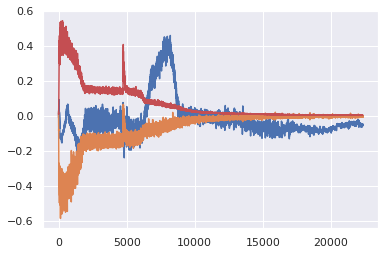

Models loaded!


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f'Using : {device}')
    print(torch.cuda.get_device_name(device))
else :
    print(f'Using : {device}')





"""Creating the training set of sine signals"""



source_filename =  dataPath + '/sinedata_v2.csv'
sine_data = GetSineData(source_file = source_filename)
data_loader = torch.utils.data.DataLoader(sine_data, batch_size=sample_size, shuffle=True, drop_last=True)
seq_length = sine_data[0].size()[0] #Number of features

if ecg:
  ecg_path =  dataPath + '/ecg_data_v1.csv'
  sine_data = GetECGData(source_file = ecg_path)
  data_loader = torch.utils.data.DataLoader(sine_data, batch_size=sample_size, shuffle=True)
  seq_length = 140






# Num batches
num_batches = len(data_loader)

"""Creating the Test Set"""
test_filename = dataPath + '/sinedata_test_v2.csv' #'./sinedata_test_v2.csv'

sine_data_test = GetSineData(source_file = test_filename)
data_loader_test = torch.utils.data.DataLoader(sine_data_test, batch_size=sample_size, shuffle=True)





""" Evaluation of GAN with 1 CNN Layer in Discriminator
##Generator and Discriminator training phase
"""
#minibatch_out = [5] #[0,3,5,8,10]
#for minibatch_layer in tq.tqdm(minibatch_out):
#path = "./output/Run_"+str(today.strftime("%d_%m_%Y"))+"_"+ str(datetime.datetime.now().time()).split('.')[0]


if not os.path.exists(path):
        os.makedirs(path)




#Initialising the generator and discriminator
generator = Generator(seq_length,sample_size,n_features = noise_features, hidden_dim =  hidden_nodes_g,num_layers= layers, tanh_output = tanh_layer, bidirectional = bidir).to(device)
discriminator = Discriminator(seq_length, sample_size ,minibatch_normal_init = minibatch_normal_init_, minibatch = minibatch_layer,num_cv = num_cvs, cv1_out = cv1_out,cv1_k = cv1_k, cv1_s = cv1_s, p1_k = p1_k, p1_s = p1_s, cv2_out= cv2_out, cv2_k = cv2_k, cv2_s = cv2_s, p2_k = p2_k, p2_s = p2_s).to(device)
#Loss function 
loss_1 = torch.nn.BCELoss()



#Defining optimizer
if opt_adam:
    discriminator_opt = torch.optim.Adam(discriminator.parameters(),lr = lr_d, betas=[beta1, beta2])
    generator_opt = torch.optim.Adam(generator.parameters(),lr = lr_g,  betas=[beta1, beta2])
else:
    discriminator_opt = torch.optim.RMSprop(discriminator.parameters(), lr=learning_rate)
    generator_opt = torch.optim.RMSprop(generator.parameters(), lr=learning_rate)

gradient_p = []
G_losses = []
D_losses = []
mmd_list = []
series_list = np.zeros((1,seq_length))


if loadModel:
    checkpoint = torch.load(loadPath)#torch.load(loadPath)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_opt.load_state_dict(checkpoint['optimizerG_state_dict'])
    discriminator_opt.load_state_dict(checkpoint['optimizerD_state_dict'])
    gradient_p = checkpoint['gradient_p']
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    mmd_list = checkpoint['mmd_list']
    series_list = checkpoint['series_list']
    epoch_loaded = checkpoint['epoch']
    
    plt.plot(G_losses)
    plt.plot(D_losses)
    plt.plot(mmd_list)
    plt.plot(gradient_p)
    plt.show()
    print('Models loaded!')



wandb.watch([generator, discriminator], log='all', log_freq=80*1)
#wandb.watch(, log='all',  log_freq=80*2)


generator.train()
discriminator.train()



gradient_penalty = torch.ones(1).to(device)


input1 = torch.FloatTensor(sample_size, 2).to(device)
input2 = torch.FloatTensor(sample_size, 2).to(device)
interp_alpha = torch.FloatTensor(sample_size, 1).to(device)

fixed_noise = torch.FloatTensor(sample_size, 2).normal_(0, 1).to(device)
perturbation = torch.FloatTensor(sample_size,2).to(device)   


itera = -1

for epoch in tq.tqdm(range(num_epoch)):
    if epoch <= epoch_loaded: continue

    # if epoch == 1:
    #   lr_d = lr_d * 100
    #   lr_g = lr_g * 100
    
    # if epoch == 30:
    #       lr_d = lr_d / 100
    #       lr_g = lr_g / 100
        

    dctr = 0
    gctr = 0
    for n_batch, sample_data in  enumerate(tq.tqdm(data_loader)): #tq.tqdm(enumerate(data_loader)): 
    
      itera = itera + 1

      #for d in range(D_rounds):
      
      #Train Discriminator on Fake Data
      discriminator.zero_grad()
      dctr = dctr + 1

      #Generating the noise and label data
      #noise_sample = Variable(noise(len(sample_data),seq_length))
      noise_sample = noise(len(sample_data), seq_length,noise_features )

      #Use this line if generator outputs hidden states: fake_data, (h_g_n,c_g_n) = generator.forward(noise_sample,h_g)
      fake_data = generator(noise_sample).detach()

      critic_out_fake = discriminator(fake_data)
      # tr = 0
      # for n in sample_data:
      #   if tr < 10:
      #     plt.plot(n)
      #     tr = 1 + tr
      # plt.show()
      #Train Discriminator on Real Data 
      real_data = sample_data.requires_grad_().to(device=device, dtype=torch.float)
      


      critic_out_real  = discriminator(real_data)


      loss_discriminator = critic_out_fake.mean() - critic_out_real.mean()
      

      
      if lipschitz_constraint == 0:
          # Calculate interpolation
          epsilon = torch.rand(sample_size, 1).to(device)
          epsilon = epsilon.expand_as(real_data)
          interpolated = epsilon * real_data + (1 - epsilon) * fake_data # interpolates := xhat        
          interpolated = Variable(interpolated, requires_grad=True).to(device)
          # Calculate probability of interpolated examples
          prob_interpolated = discriminator(interpolated)
          gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated, grad_outputs=torch.ones_like(prob_interpolated), create_graph=True, retain_graph=True)[0]
          # set up tensors (torch administrativa)
          # Gradients have shape (batch_size, num_channels, img_width, img_height),
          # so flatten to easily take norm per example in batch
          gradients = gradients.view(sample_size, -1)
          # Derivatives of the gradient close to 0 can cause problems because of
          # the square root, so manually calculate norm and add epsilon
          gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
          gradient_penalty =penalty_weight * ((gradients_norm - 1) ** 2).mean()        
          loss_discriminator = loss_discriminator +   gradient_penalty
      
      elif lipschitz_constraint == 1:
              dist = ((real_data-fake_data)**2).sum(1)**0.5
              lip_est = (critic_out_real.mean()-critic_out_fake.mean()).abs()/(dist+1e-8)
              lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
              gradient_penalty = lip_loss
              loss_discriminator = loss_discriminator + lip_loss
      elif lipschitz_constraint == 3:           
              interp_alpha.resize_(sample_size, 1)
              interp_alpha.uniform_()
              interp_points = Variable((interp_alpha.expand_as(real_data.data)*real_data.data+(1-interp_alpha.expand_as(real_data.data))*fake_data.data), requires_grad=True)
              errD_interp_vec = discriminator(interp_points)
              errD_gradient, = torch.autograd.grad(errD_interp_vec.sum(), interp_points, create_graph=True)
              lip_est = (errD_gradient**2).view(sample_size,-1).sum(1)**0.5 # updated: bug fix: added **0.5
              lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
              gradient_penalty = lip_loss
              loss_discriminator = loss_discriminator + lip_loss
      elif lipschitz_constraint == 4 or lipschitz_constraint == 5:
          if lipschitz_constraint == 4:
            # this tries to match DRAGAN
            perturbation.resize_as_(real_data.data)
            perturbation.uniform_()
            perturbation *= 0.5*real_data.data.std()
            interp_alpha.resize_(sample_size, 1)  
            interp_alpha.uniform_()
            perturbation *= interp_alpha.expand_as(perturbation)
          else:
            # the choice of perturbation and leaving out alpha differs from the DRAGAN article
            perturbation.resize_as_(real_data.data)
            perturbation.normal_()
            perturbation *= 0.25*real_data.data.std(0).expand_as(perturbation)


          perturbation += real_data.data
          interp_points = Variable(perturbation, requires_grad=True)
          errD_interp_vec = discriminator(interp_points)
          errD_gradient, = torch.autograd.grad(errD_interp_vec.sum(), interp_points, create_graph=True)
          lip_est = (errD_gradient**2).view(sample_size,-1).sum(1)**0.5
          lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
          gradient_penalty = lip_loss
          loss_discriminator = loss_discriminator + lip_loss

      elif lipschitz_constraint == 10:
          gradient_penalty = penalty_weight * wgan_gp_reg(discriminator, real_data, fake_data, center)
          loss_discriminator = loss_discriminator +  gradient_penalty
          #print(gradient_penalty)
      elif lipschitz_constraint == 11:
          
          for p in discriminator.parameters():
            p.data.clamp_(-0.1, 0.1)

        


      loss_discriminator.backward()

      discriminator_opt.step() #Updating the weights based on the predictions for both real and fake calculations.
        
        
    

      #Train Generator  
      #for g in range(G_rounds):

      gctr = gctr + 1

      generator.zero_grad()

      #noise_sample = Variable(noise(len(sample_data), seq_length))
      noise_sample = noise(len(sample_data), seq_length, noise_features)
      #Use this line if generator outputs hidden states: gen_fake_data, (h_g_n,c_g_n) = generator.forward(noise_sample,h_g)
      fake_data = generator(noise_sample)
      critic_out_fake = discriminator(fake_data)
      loss_generator = - critic_out_fake.mean()
      #loss_generator = torch.mean(critic_out_fake)
      loss_generator.backward() #loss_generator.backward(mone) #https://medium.com/@zhang_yang/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29
      #error_gen = loss_1(y_pred_gen,torch.ones([len(sample_data),1]).to(device))
      #error_gen.backward()
      generator_opt.step()
        
      gradient_p.append(gradient_penalty.item())
      G_losses.append(loss_generator.item())
      D_losses.append((loss_discriminator).item())
      # if n_batch % 2 == 0:
      #   with torch.no_grad():
      #       fake = generator(noise(len(sample_data), seq_length, noise_features)).detach().cpu()
      #       generated_sample = torch.zeros(1,seq_length).to(device)
      #       testloader=torch.utils.data.DataLoader(sine_data_test, batch_size=sample_size, shuffle=True)
                  
      #       for n_batch, sample_data in enumerate(testloader):
      #           noise_sample_test = noise(sample_size, seq_length, noise_features)
      #           generated_data = generator.forward(noise_sample_test).detach().squeeze()
      #           generated_sample = torch.cat((generated_sample,generated_data),dim = 0)
                      
      #       # Getting the MMD Statistic for each Training Epoch
      #       generated_sample = generated_sample[1:][:]
      #       sigma = [pairwisedistances(sine_data_test[:].type(torch.DoubleTensor),generated_sample.type(torch.DoubleTensor).squeeze())] 
      #       mmd = MMDStatistic(len(sine_data_test[:]),generated_sample.size(0))
      #       mmd_eval = mmd(sine_data_test[:].type(torch.DoubleTensor),generated_sample.type(torch.DoubleTensor).squeeze(),sigma, ret_matrix=False)
      #       mmd_list.append(mmd_eval.item())
      # else:
      #   mmd_list.append(mmd_eval.item())
#     torch.save({
#             'generator_state_dict': generator.state_dict(),
#             'discriminator_state_dict': discriminator.state_dict(),
#             'optimizerG_state_dict': generator_opt.state_dict(),
#             'optimizerD_state_dict': discriminator_opt.state_dict()   
#             }, path + 'save' + str(n)+'.tar')
#    print(f'lossD: {loss_discriminator.item()} lossG: {loss_generator.item()}')
    wandb.log({"criticReal":critic_out_real, "criticFake":critic_out_fake  , "Critic": loss_discriminator, "Generator": loss_generator, "GradientPenalty": gradient_penalty})
    #torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))

    #print(f'dctr: {dctr/gctr} , dloss {loss_discriminator.item()}')
    
        #plt.figure(figsize=(13,8))  
        #plt.yscale('symlog')
        #plt.plot(G_losses,'-r',label='Generator Error')
        #plt.plot(D_losses, '-b', label = 'Discriminator Error')
        #plt.plot(gradient_p, '-g', label= 'Gradient Penalty')
        # plt.plot(mmd_list, '-y', label= 'MMD Score')
        #plt.title('GAN Errors, lr=' +str(learning_rate))
        #plt.legend()
        #plt.show()
                    #for i in range(10):
                #plt.plot(fake[i], label= 'd:' + str(fd[i][0]))
           #     plot_df.append(pd.DataFrame(fake[i].T).astype("float"))
    with torch.no_grad():
        discriminator.eval()
        generator.eval()
        fake = generator(noise(len(sample_data), seq_length, noise_features)).detach().cpu()
        fd = discriminator(fake.to(device)).detach().cpu()                
        num_samples = 10
        fig = go.Figure()
        for i in range(num_samples):
            fig.add_trace(go.Scatter(x=np.arange(seq_length), y=fake[i],
                mode='lines',
                name='s'+str(i)))

        #fig.update_layout(xaxis_title='t', yaxis_title='y')

        wandb.log({'Epoch ' + str(epoch): fig})
        
        #real:
        if epoch == 1:
          fig = go.Figure()
          for i in range(num_samples):
              fig.add_trace(go.Scatter(x=np.arange(seq_length), y=real_data[i],
                  mode='lines',
                  name='real'))

          #fig.update_layout(xaxis_title='t', yaxis_title='y')

          wandb.log({'Real ': fig})

        discriminator.train()
        generator.train()
        
                 

        series_list = np.append(series_list,fake[0].numpy().reshape((1,seq_length)),axis=0)

        #Saving the parameters of the model to file for each epoch
        saveModel(path, epoch)




        

#Dumping the errors and mmd evaluations for each training epoch.
with open(path+'/generator_losses.txt', 'wb') as fp:
    pickle.dump(G_losses, fp)
with open(path+'/discriminator_losses.txt', 'wb') as fp:
    pickle.dump(D_losses, fp)   
with open(path+'/mmd_list.txt', 'wb') as fp:
    pickle.dump(mmd_list, fp)

#Plotting the error graph
plt.plot(G_losses,'-r',label='Generator Error')
plt.plot(D_losses, '-b', label = 'Discriminator Error')
plt.title('GAN Errors in Training')
plt.legend()
plt.savefig(path+'/GAN_errors.png')
plt.show()
plt.close()


#Plot a figure for each training epoch with the MMD value in the title
# i = 0
# while i < num_epoch:
#   if i%3==0:
#     fig, ax = plt.subplots(3,1,constrained_layout=True)
#     fig.suptitle("Generated fake data")
#   for j in range(0,2):
#     ax[j].plot(series_list[i][:])
#     ax[j].set_title('Epoch '+str(i)+ ', MMD: %.4f' % (mmd_list[i]))
#     i = i+1
#   plt.savefig(path+'/Training_Epoch_Samples_MMD_'+str(i)+'.png')
#   plt.close(fig) 
  
#Checking the diversity of the samples:
generator.eval()
test_noise_sample = noise(sample_size, seq_length, noise_features)
gen_data= generator.forward(test_noise_sample).detach()

plt.title("Generated Sine Waves")
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-b')
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-r')
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-g')
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-', color = 'orange')
plt.savefig(path+'/Generated_Data_Sample1.png')
plt.close()

print('Training Complete!')
torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizerG_state_dict': generator_opt.state_dict(),
        'optimizerD_state_dict': discriminator_opt.state_dict()   
        }, path + '/modelComplete' + str(trainCounter)+'.tar')
print('Model saved in Drive!')


In [ ]:
saveModel('/content/', 199)
wandb.save('epoch199.tar', base_path='/content')





In [ ]:
num_samples = 9
num_classes = 40
df = pd.DataFrame(index=range(num_samples), columns=[str(x) for x in range(num_classes)])
for i in range(num_samples):
    df.iloc[i] = torch.randn(1, num_classes).numpy().round(2)

print(df)

In [ ]:
# beta 0 -> 0.5
#     if epoch <20:
#       lr_d = lr_d * 10
#       lr_g = lr_g * 10
#     if epoch == 20:
#       lr_d = lr_d * 0.1
#       lr_g = lr_g * 0.1



In [ ]:
import os

print('remount storage!')
torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizerG_state_dict': generator_opt.state_dict(),
        'optimizerD_state_dict': discriminator_opt.state_dict()   
        }, 'wgan2.tar')
print('Model saved!')


In [ ]:
testNoise = noise(sample_size, int(seq_length*1), noise_features)
testOut = generator(testNoise)
for n in testOut:
  plt.plot(n.detach().cpu())
plt.show()

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D



testNoise = noise(sample_size, int(seq_length*10), noise_features)
testOut = generator(testNoise)

for n in testOut:
    plt.plot(n.detach().cpu())
plt.show()

plt.show()
plt.figure(figsize=(16,10))
plt.plot(testOut[0].detach().cpu(), 'black') 
plt.plot(testOut[0].detach().cpu() , 'bisque')
plt.plot(testOut[1].detach().cpu() , 'aquamarine')
plt.plot(testOut[2].detach().cpu() , 'lightsteelblue')
plt.plot(testOut[3].detach().cpu() , 'lightcoral')
plt.plot(testOut[4].detach().cpu() , 'cornsilk')
plt.plot(testOut[5].detach().cpu() , 'thistle')
plt.plot(testOut[6].detach().cpu() , 'peachpuff')
plt.plot(testOut[7].detach().cpu() , 'powderblue')
plt.show()


r1u =  0 # delta
r1l = -0 # delta
r2u =  0 # amplitude
r2l = -0 # amplitude
r3u =  0 # freq (+ amplitude)
r3l = -0 # freq (+ amplitude)
r4u =  0 # freq (+ amplitude)
r4l = -0 # freq (+ amplitude)

for b in range(2):
  r1 = random.uniform(r1u,r1l)
  r2 = random.uniform(r2u,r2l)
  r3 = random.uniform(r3u,r3l)    #-> noise_features = 3
  r4 = random.uniform(r4u,r4l)

  #r4 = random.uniform(-1,1)   #-> noise_features = 4 ...
  for i in range(seq_length):
    testNoise[b][i][0] = r1  
    testNoise[b][i][1] = r2 
    testNoise[b][i][2] = r3 
    testNoise[b][i][3] = r4
    
# fig = plt.figure(constrained_layout=True)
# ax = fig.add_subplot( projection='3d')  
# for b in range(sample_size):
#     ax.scatter(testNoise[b][0][0].cpu(), testNoise[b][0][1].cpu(), testNoise[b][0][2].cpu(), marker=".")

# ax.set_xlabel('Freq')
# ax.set_ylabel('Ampl')
# ax.set_zlabel('delta')
# plt.show()
for i in range(seq_length):
    testNoise[0][i][0] = r1  
    testNoise[0][i][1] = r2 
    testNoise[0][i][2] = r3 
    testNoise[0][i][3] = r4
    testNoise[1][i][0] = r1 - 0.0
    testNoise[1][i][1] = r2 - 0.0
    testNoise[1][i][2] = r3 + 0.0
    testNoise[1][i][3] = r4 + 0.0

testOut = generator(testNoise)

plt.show()
plt.figure(figsize=(16,10))
plt.plot(testOut[0].detach().cpu(), 'black') 
plt.plot(testOut[1].detach().cpu() , 'red')
plt.show()